# Modeling Notebook - Adapted From reddit binary classification

We sprint through some things here to see if we can get to some sort of MVP on our capstone so we can then begin trying to improve upon things.

In [1]:
#Grabbing some mates

import warnings #I receive an unsightly deprecation warning for matplotlib. This suppresses it
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import BernoulliNB

from nltk.util import ngrams



from sklearn.feature_extraction import text

#### Importing my pulled data

In [2]:
bechdel_script_df = pd.read_csv('../data/bechdel_script_df.csv')

In [3]:
bechdel_script_df.head()

,Unnamed: 0,title,script,simple_bechdel,women
0,0,warrior,WARRIOR ...,0,13
1,1,collateral,COLLA...,0,8
2,6,gamer,GAMER ...,0,24
3,7,wanted,WANTED ...,0,7
4,8,2001: a space odyssey,2001: A SPACE ODYSSEY Screenplay by...,0,9


Here we are going to keep the features that we are going to use going forward.

In [4]:
bechdel_script_df.drop(columns=['Unnamed: 0'], axis =1 , inplace=True)

In [5]:
bechdel_script_df.head()

,title,script,simple_bechdel,women
0,warrior,WARRIOR ...,0,13
1,collateral,COLLA...,0,8
2,gamer,GAMER ...,0,24
3,wanted,WANTED ...,0,7
4,2001: a space odyssey,2001: A SPACE ODYSSEY Screenplay by...,0,9


In [6]:
bechdel_script_df.set_index('title')

,script,simple_bechdel,women
title,,,
warrior,WARRIOR ...,0,13
collateral,COLLA...,0,8
gamer,GAMER ...,0,24
wanted,WANTED ...,0,7
2001: a space odyssey,2001: A SPACE ODYSSEY Screenplay by...,0,9
...,...,...,...
shakespeare in love,SHAKESPEARE IN LOVE ...,1,12
surrogates,SURROGATES ...,0,13
smashed,SMASHED ...,1,16


### Splitting Info Into Two Dataframes

For the purpose of EDA, we are going to split the dataframe in two to see the difference between scripts that pass The Bechdel Test and scripts that don't.

In [7]:
bechdel_pass_df = bechdel_script_df.query('simple_bechdel == 1')
bechdel_fail_df = bechdel_script_df.query('simple_bechdel == 0')

In [8]:
bechdel_pass_df.head()

,title,script,simple_bechdel,women
5,cruel intentions,CRUEL INTENTIONS ...,1,9
6,blast from past,BLAST FROM THE PAST - by Bill Kelly and Hugh W...,1,21
7,ed wood,ED WOOD ...,1,17
9,queen of damned,QUEEN OF THE DAMNED Written by...,1,9
11,almost famous,"ALMOST FAMOUS Cameron Crowe December, 1998 U...",1,17


In [9]:
bechdel_fail_df.head()

,title,script,simple_bechdel,women
0,warrior,WARRIOR ...,0,13
1,collateral,COLLA...,0,8
2,gamer,GAMER ...,0,24
3,wanted,WANTED ...,0,7
4,2001: a space odyssey,2001: A SPACE ODYSSEY Screenplay by...,0,9


#### We have some additional stop words that need to be removed:

I am going to include these below

In [10]:
extra_stop_words = ['ve', 'int', 'ext', 'just', 'don', 'know', 'like', 'day', 'continued', 'got', 'away', 'looks', 'cont',
                    'door', 'll', 'night', 'room', 'right', 'look', 'www', 'pdf', 'little', 'house', 'eyes', 'face',
                    'screentalk', 'later', 'revs', '03', '10', '12', '21', 'draft', 'screening', 'script', 'revised']

In [11]:
stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)

In [12]:
bechdel_pass_cvec = CountVectorizer(stop_words= stop_words)
bechdel_fail_cvec = CountVectorizer(stop_words= stop_words)

In [13]:
pass_bechdel_cvec = bechdel_pass_cvec.fit_transform(bechdel_pass_df['script'])
fail_bechdel_cvec = bechdel_fail_cvec.fit_transform(bechdel_fail_df['script'])

In [14]:
pass_bechdel_cvec

<240x76198 sparse matrix of type '<class 'numpy.int64'>'
	with 760428 stored elements in Compressed Sparse Row format>

In [15]:
fail_bechdel_cvec

<224x70840 sparse matrix of type '<class 'numpy.int64'>'
	with 718568 stored elements in Compressed Sparse Row format>

In [16]:
pass_bechdel_cvec_df = pd.DataFrame(pass_bechdel_cvec.todense(), columns=bechdel_pass_cvec.get_feature_names())
fail_bechdel_cvec_df = pd.DataFrame(fail_bechdel_cvec.todense(), columns=bechdel_fail_cvec.get_feature_names())

In [17]:
pass_bechdel_cvec_df.sum().sort_values(ascending=False).head(25)

man        7811
oh         7639
turns      7635
going      7589
want       7295
think      7178
time       7171
hand       6720
car        6538
come       6530
head       6442
good       6231
takes      6037
cut        5985
way        5955
did        5756
yeah       5446
let        5325
looking    4956
mr         4868
phone      4758
walks      4738
say        4734
open       4724
really     4679
dtype: int64

In [18]:
fail_bechdel_cvec_df.sum().sort_values(ascending=False).head(25)

man        10141
cut         7387
turns       6970
time        6691
head        6647
car         6577
going       6260
hand        6232
want        6229
come        5991
think       5865
way         5730
good        5456
takes       5251
jack        4701
looking     4672
did         4668
pulls       4592
beat        4539
let         4522
hands       4364
walks       4319
open        4305
oh          4257
phone       4222
dtype: int64

# Exploratory Data Analysis

Let's explore bi-grams to see the overall difference in word usage.

In [19]:
bigram_bechdel_pass = CountVectorizer(ngram_range=(2,2), stop_words=stop_words)
bigram_bechdel_pass_x = bigram_bechdel_pass.fit_transform(bechdel_pass_df['script'])
bigram_bechdel_pass_x

<240x1872370 sparse matrix of type '<class 'numpy.int64'>'
	with 2342185 stored elements in Compressed Sparse Row format>

In [20]:
bigram_bechdel_pass_df = pd.DataFrame(bigram_bechdel_pass_x.todense(), columns=bigram_bechdel_pass.get_feature_names())

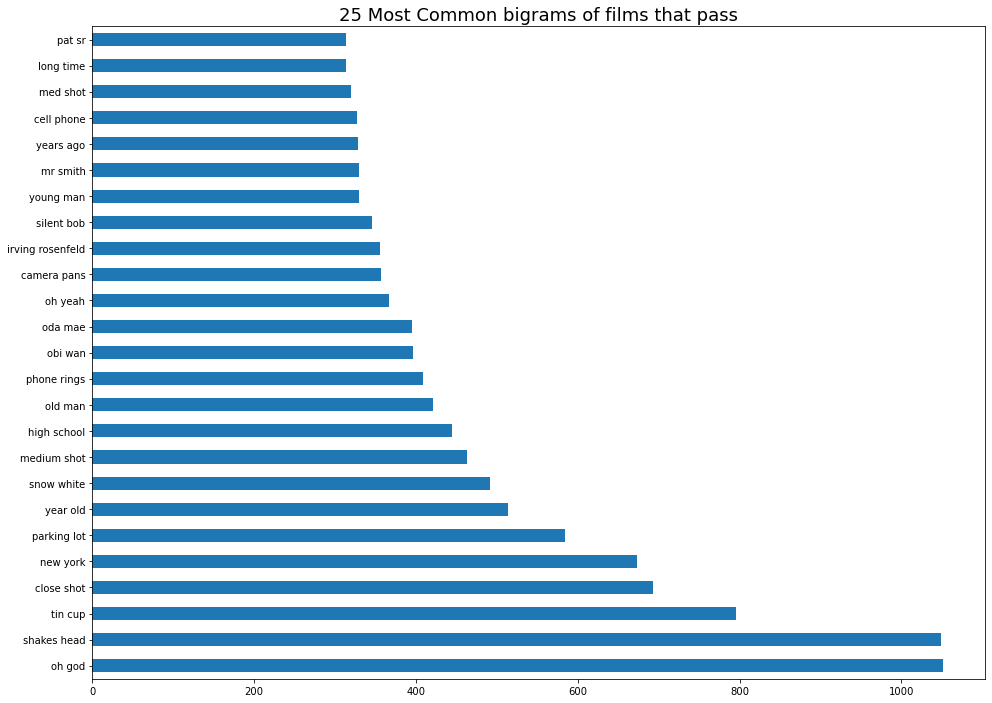

In [21]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common bigrams of films that pass', fontdict={'fontsize':18})
bigram_bechdel_pass_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

##### Bigrams for films that fail The Bechdel Test

In [22]:
bigram_bechdel_fail = CountVectorizer(ngram_range=(2,2), stop_words=stop_words)
bigram_bechdel_fail_x = bigram_bechdel_fail.fit_transform(bechdel_fail_df['script'])
bigram_bechdel_fail_x

<224x1769262 sparse matrix of type '<class 'numpy.int64'>'
	with 2191872 stored elements in Compressed Sparse Row format>

In [23]:
bigram_bechdel_fail_df = pd.DataFrame(bigram_bechdel_fail_x.todense(), columns=bigram_bechdel_fail.get_feature_names())

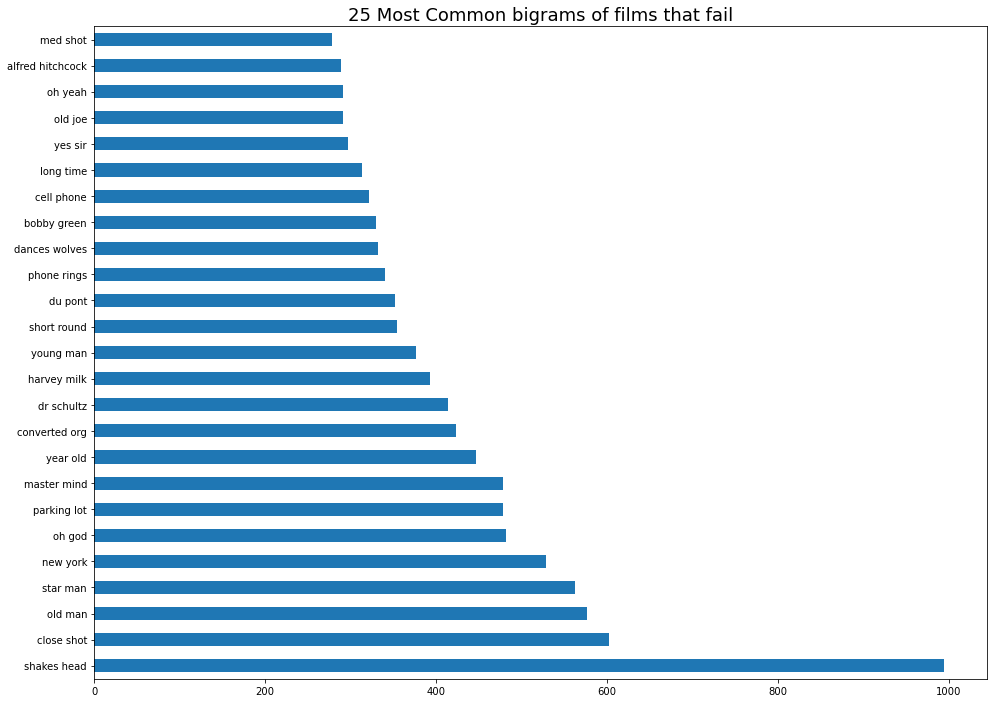

In [24]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common bigrams of films that fail', fontdict={'fontsize':18})
bigram_bechdel_fail_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

### Let's explore the data through some trigrams:

I think the combination of words into phrases could be useful here.

In [25]:
trigram_bechdel_pass = CountVectorizer(ngram_range=(3,3), stop_words=stop_words)
trigram_pass_x = trigram_bechdel_pass.fit_transform(bechdel_pass_df['script'])
trigram_pass_x

<240x2651126 sparse matrix of type '<class 'numpy.int64'>'
	with 2674948 stored elements in Compressed Sparse Row format>

In [26]:
trigram_bechdel_pass_df = pd.DataFrame(trigram_pass_x.todense(), columns=trigram_bechdel_pass.get_feature_names())

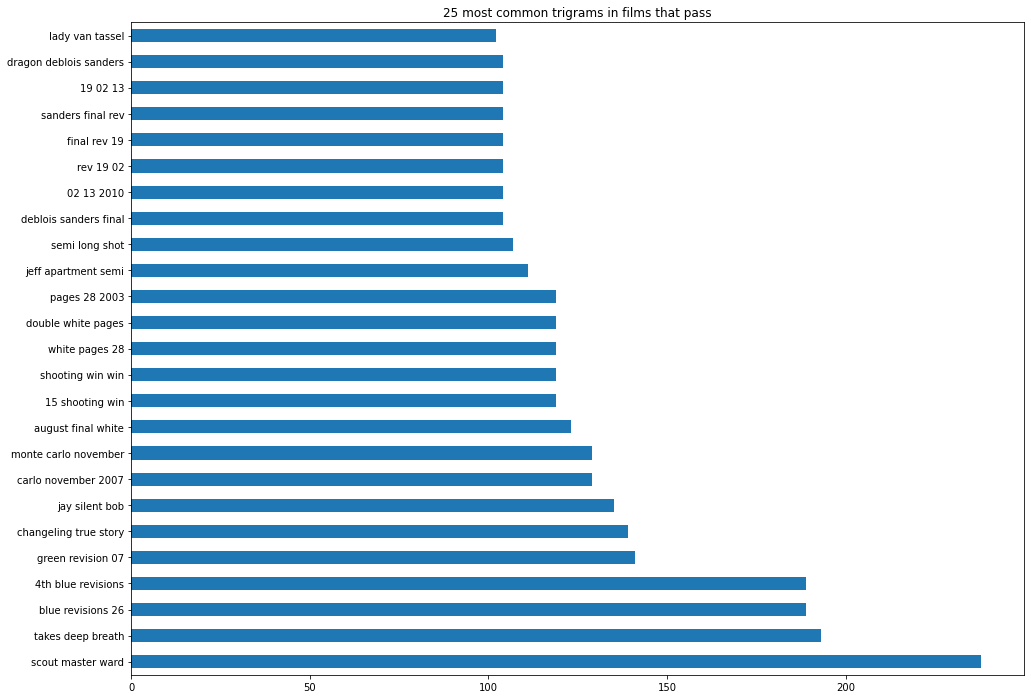

In [27]:
plt.figure(figsize=(16,12))
plt.title('25 most common trigrams in films that pass')
trigram_bechdel_pass_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [28]:
trigram_bechdel_fail = CountVectorizer(ngram_range=(3,3), stop_words=stop_words)
trigram_fail_x = trigram_bechdel_fail.fit_transform(bechdel_fail_df['script'])
trigram_fail_x

<224x2471347 sparse matrix of type '<class 'numpy.int64'>'
	with 2491884 stored elements in Compressed Sparse Row format>

In [29]:
trigram_bechdel_fail_df = pd.DataFrame(trigram_fail_x.todense(), columns=trigram_bechdel_fail.get_feature_names())

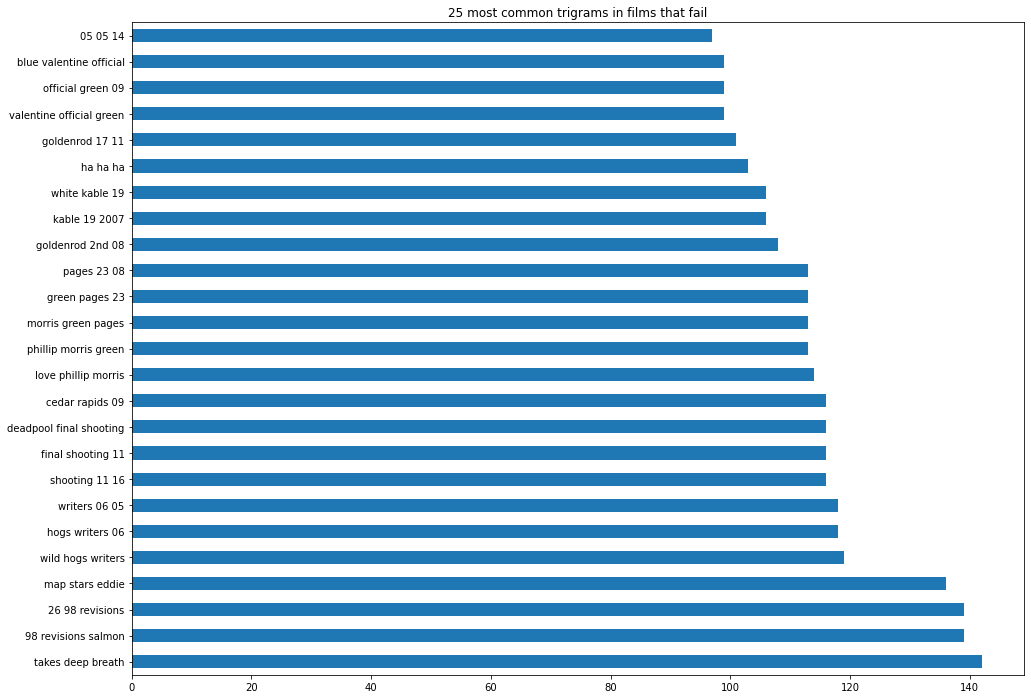

In [30]:
plt.figure(figsize=(16,12))
plt.title('25 most common trigrams in films that fail')
trigram_bechdel_fail_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

Exploring bigrams and trigrams has been useful in cleaning up the data and removing stop words for modeling.

### Exploring Topic Modeling

Below we are going to explore the differences between scripts that pass The Bechdel Test and scripts that don't. There could likely be a difference in what is discussed across them. Let's see what comes of it.

# The Modeling Begins!

In [31]:
X = bechdel_script_df['script']
y = bechdel_script_df['simple_bechdel']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [32]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('logreg', LogisticRegression())
        
])

In [33]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=frozenset({'03', '10', '12', '21',
                                                       'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyh

In [34]:
pipe.score(X_train, y_train)

1.0

In [35]:
pipe.score(X_test, y_test)

0.6206896551724138

1?!?! It appears my model is overfit. I am curious as to what is causing the difference.

In [36]:
preds = pipe.predict(X_test)

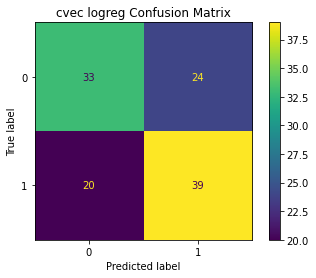

In [37]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()
plt.title('cvec logreg Confusion Matrix');

In [38]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60        57
           1       0.62      0.66      0.64        59

    accuracy                           0.62       116
   macro avg       0.62      0.62      0.62       116
weighted avg       0.62      0.62      0.62       116



### Let's try Tfid and Logistic Regression

In [39]:
pipe_tfid_logreg = Pipeline([
    ('tvec', TfidfVectorizer(stop_words= stop_words)),
    ('logreg', LogisticRegression())
        
])

In [40]:
pipe_tfid_logreg.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(stop_words=frozenset({'03', '10', '12', '21',
                                                       'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyh

In [41]:
pipe_tfid_logreg.score(X_train, y_train)

0.9885057471264368

In [42]:
pipe_tfid_logreg.score(X_test, y_test)

0.5258620689655172

In [43]:
preds_tfid_logreg = pipe.predict(X_test)

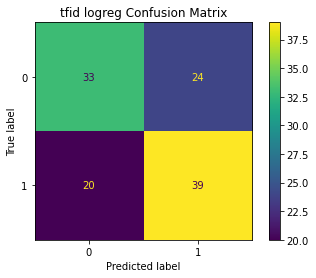

In [44]:
cm = confusion_matrix(y_test, preds_tfid_logreg)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()
plt.title('tfid logreg Confusion Matrix');

In [45]:
print(classification_report(y_test, preds_tfid_logreg))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60        57
           1       0.62      0.66      0.64        59

    accuracy                           0.62       116
   macro avg       0.62      0.62      0.62       116
weighted avg       0.62      0.62      0.62       116



#### Let's try out another model: TfidfVectorizer with Bernoulli Naive Bayes

In [46]:
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words= stop_words)),
    ('nb', BernoulliNB())
])

In [47]:
pipe_tvec_nb.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(stop_words=frozenset({'03', '10', '12', '21',
                                                       'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyh

In [48]:
pipe_tvec_nb.score(X_train, y_train)

0.9827586206896551

In [49]:
pipe_tvec_nb.score(X_test, y_test)

0.5689655172413793

Well, this is better than the information from the logistic regression and count vectorizer. At least we are now in the MVP territory!

In [50]:
pipe_tvec_nb_preds = pipe_tvec_nb.predict(X_test)

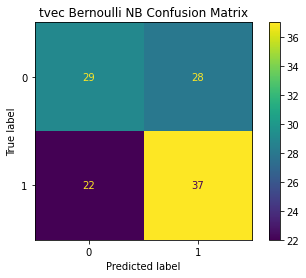

In [51]:
cm = confusion_matrix(y_test, pipe_tvec_nb_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()
plt.title('tvec Bernoulli NB Confusion Matrix');

In [52]:
print(classification_report(y_test, pipe_tvec_nb_preds))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54        57
           1       0.57      0.63      0.60        59

    accuracy                           0.57       116
   macro avg       0.57      0.57      0.57       116
weighted avg       0.57      0.57      0.57       116



#### Another K-NN model made that did not include GridSearch this time around, as I kept running my models as I cleaned the data and added stop words to the list.

This model was included in my presentation.

In [53]:
pipe_knn_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [54]:
pipe_knn_2.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=frozenset({'03', '10', '12', '21',
                                                       'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyh

In [55]:
pipe_knn_2.score(X_train, y_train)

0.5862068965517241

In [56]:
pipe_knn_2.score(X_test, y_test)

0.4827586206896552

In [57]:
knn_2_preds = pipe_knn_2.predict(X_test)

In [58]:
print(classification_report(y_test, knn_2_preds))

              precision    recall  f1-score   support

           0       0.49      0.91      0.63        57
           1       0.44      0.07      0.12        59

    accuracy                           0.48       116
   macro avg       0.47      0.49      0.38       116
weighted avg       0.46      0.48      0.37       116



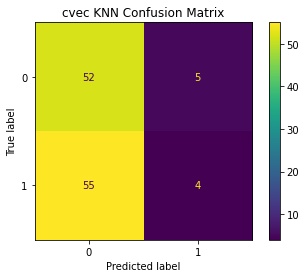

In [59]:
cm = confusion_matrix(y_test, knn_2_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()
plt.title('cvec KNN Confusion Matrix');

This model has an incredibly bad recall score.